In [23]:
import datetime, logging, os, sys, math, random
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from keras import Sequential, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image as Img
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import albumentations as A

from ImageDataAugmentor.image_data_augmentor import *
from sklearn.model_selection import train_test_split, StratifiedKFold
from albumentations.core.composition import Compose, OneOf
from albumentations.core.transforms_interface import ImageOnlyTransform


In [2]:
devices = tf.config.list_physical_devices('GPU')
for device in devices:
   tf.config.experimental.set_memory_growth(device, True) 
print(devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
TASK = "sorghum-id"
TASK_ID = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
PATH = os.path.abspath(os.path.join(
    os.getcwd(), "../../../../datasets/sorghum-id-fgvc-9"))+"/"

TRAIN_DIR = PATH+'train_images/'
TEST_DIR = PATH+'test/'

save_dir    = '../results/sorghum/'+TASK_ID+'/'
log_dir     = os.path.join("../logs/",''.join([TASK,"-",TASK_ID]))
model_dir   = os.path.join("../models/",''.join([TASK,"-",TASK_ID]))+'/'

In [4]:
NUM_GPUS = len(devices)

base_batch_size = 16
batch_size = base_batch_size*NUM_GPUS
epoch = 20
WIDTH = 512
HEIGHT = 512
WEIGHTS = "imagenet"
MODEL = "EfficientNetB4"

DEBUG = True

In [244]:
image_df = pd.read_csv(PATH+'train_cultivar_mapping.csv')
image_df.dropna(inplace=True)

if DEBUG:
    image_df = image_df.groupby('cultivar').apply(lambda x: x.sample(5))
    image_df.reset_index(drop=True)
    epoch = 10
image_df

image   cultivar
cultivar                                                
PI_144134 20159  2017-06-20__12-55-17-873.png  PI_144134
          14005  2017-06-20__12-55-15-874.png  PI_144134
          21565  2017-06-16__12-32-20-347.png  PI_144134
          7425   2017-06-29__12-09-10-608.png  PI_144134
          12442  2017-06-28__11-51-10-365.png  PI_144134
...                                       ...        ...
PI_92270  2568   2017-06-04__12-49-54-953.png   PI_92270
          21652  2017-06-20__11-29-30-187.png   PI_92270
          10544  2017-06-17__12-53-27-826.png   PI_92270
          11971  2017-06-23__11-32-44-428.png   PI_92270
          4407   2017-06-26__10-24-45-013.png   PI_92270

[500 rows x 2 columns]

In [245]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, valid_index in kfold.split(image_df['image'],image_df['cultivar']):
    train_images, valid_images = image_df['image'].iloc[train_index], image_df['image'].iloc[valid_index]
    train_cultivar, valid_cultivar = image_df['cultivar'].iloc[train_index], image_df['cultivar'].iloc[valid_index]

train_df= pd.DataFrame({'image':train_images, 'cultivar':train_cultivar})
val_df= pd.DataFrame({'image':valid_images, 'cultivar':valid_cultivar})

len(train_df), len(val_df)

(400, 100)

In [246]:
def clahe(img):
    c = cv.createCLAHE(clipLimit=40, tileGridSize=(16,16))
    t = np.asarray(img)
    t = cv.cvtColor(t, cv.COLOR_BGR2HSV)
    t[:,:,-1] = c.apply(t[:,:,-1])
    t = cv.cvtColor(t, cv.COLOR_HSV2BGR)
    t = Img.fromarray(t)
    t = np.array(t)
    return t

class CLAHE(ImageOnlyTransform):
    def apply(self, img, **params):
        return clahe(img)

def normalise(img):
    t = np.array(img,dtype=np.float32)/255
    return t

class NORMALISE(ImageOnlyTransform):
    def apply(self, img, **params):
        return normalise(img)


In [247]:
def get_transforms(phase: str):
    if phase == "train":
        return Compose([
                CLAHE(p=1),
                A.RandomResizedCrop(height=HEIGHT, width=WIDTH),
                A.Flip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.HueSaturationValue(p=0.5),
                A.OneOf([
                    A.RandomBrightnessContrast(p=0.5),
                    A.RandomGamma(p=0.5),
                ], p=0.5),
                OneOf([
                    A.Blur(p=0.1),
                    A.GaussianBlur(p=0.1),
                    A.MotionBlur(p=0.1),
                ], p=0.1),
                OneOf([
                    A.GaussNoise(p=0.1),
                    A.ISONoise(p=0.1),
                    A.GridDropout(ratio=0.5, p=0.2),
                    A.CoarseDropout(max_holes=16, min_holes=8, max_height=16,
                                    max_width=16, min_height=8, min_width=8, p=0.2)
                ], p=0.2),
                NORMALISE(p=1),
                
        ])
    else:
        return Compose([
                CLAHE(p=1),
                A.Resize(height=HEIGHT, width=WIDTH),
                NORMALISE(p=1),
        ])



In [248]:
train_datagen = ImageDataAugmentor(augment=get_transforms("train"))
val_datagen = ImageDataAugmentor(augment=get_transforms("val"))

In [249]:
train_augmented = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    shuffle=True,
    directory=TRAIN_DIR,
    x_col='image',
    y_col='cultivar',
    class_mode='categorical',
    target_size=(HEIGHT,WIDTH),
    batch_size=batch_size)

Found 400 validated image filenames belonging to 100 classes.


In [250]:
val_augmented = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    shuffle=True,
    directory=TRAIN_DIR,
    x_col='image',
    y_col='cultivar',
    class_mode='categorical',
    target_size=(HEIGHT,WIDTH),
    batch_size=batch_size)

Found 100 validated image filenames belonging to 100 classes.


In [251]:
num_classes = len(train_augmented.class_indices)
num_classes

100

In [252]:
class_id, num_images = np.unique(train_augmented.classes,return_counts=True)
max_value = max(num_images)
class_weights = {c : max_value/n for c,n in zip(class_id, num_images)}

In [ ]:
print(class_weights)

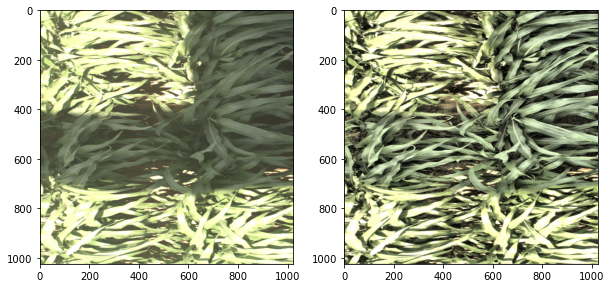

34 255
0 255


In [253]:
image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__13-04-59-234.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

CLAHE_transform = Compose([CLAHE(p=1)])

transformed_image = CLAHE_transform(image=image)["image"]

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(image)
ax = plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.show()

print(np.min(image),np.max(image))
print(np.min(transformed_image),np.max(transformed_image))

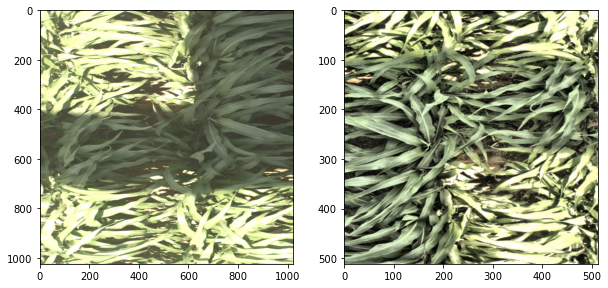

34 255
0.0 1.0


In [226]:
image = cv2.imread("/mnt/shared/scratch/fmacfarl/datasets/sorghum-id-fgvc-9/train_images/2017-06-05__13-04-59-234.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed_image = get_transforms("train")(image=image)["image"]

plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(image)
ax = plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.show()

print(np.min(image),np.max(image))
print(np.min(transformed_image),np.max(transformed_image))


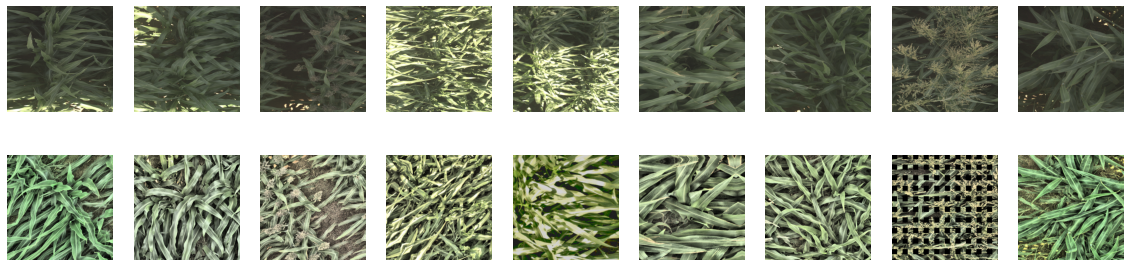

In [254]:
df = image_df.sample(9)

plt.figure(figsize=(20, 5))
for i in range(9):
    
    img_path = TRAIN_DIR+str(df["image"].values[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transformed_image = get_transforms("train")(image=img)["image"]

    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax = plt.subplot(2, 9, i + 10)
    plt.imshow(transformed_image)
    plt.axis("off")




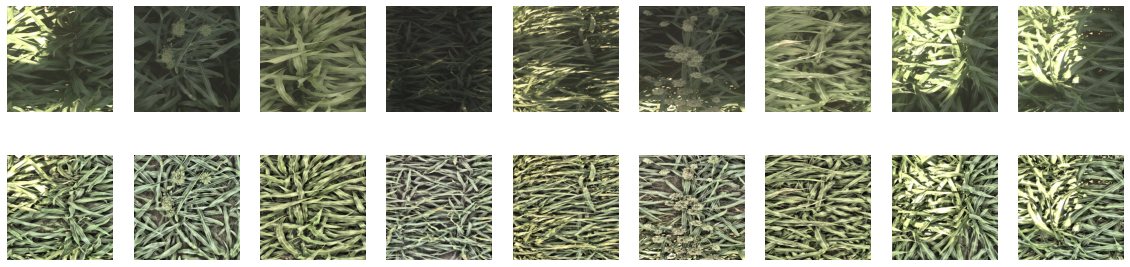

In [255]:
df = image_df.sample(9)

plt.figure(figsize=(20, 5))
for i in range(9):
    
    img_path = TRAIN_DIR+str(df["image"].values[i])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    transformed_image = get_transforms("val")(image=img)["image"]

    ax = plt.subplot(2, 9, i + 1)
    plt.imshow(img)
    plt.axis("off")
    ax = plt.subplot(2, 9, i + 10)
    plt.imshow(transformed_image)
    plt.axis("off")


In [ ]:
def create_model():

    tf.keras.backend.clear_session()

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        backbone = tf.keras.applications.Eff(
                include_top=False, weights=WEIGHTS, input_shape=(HEIGHT, WIDTH, 3))
        backbone.trainable = False
        model = Sequential([
            #TODO 
            tf.keras.Input(shape=(HEIGHT, WIDTH, 3)),
            backbone,
            layers.GlobalAveragePooling2D(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
        model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           #DEBUG:
                           tfa.metrics.F1Score(average='macro',num_classes=num_classes),
                           ])
    model.summary()
    return model

model = create_model()

In [ ]:


def create_model():

    tf.keras.backend.clear_session()

    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    with strategy.scope():
        model = Sequential([
                        tf.keras.Input(shape=(HEIGHT,WIDTH,3)),
                        tf.keras.applications.EfficientNetB4(include_top=False,weights=WEIGHTS,input_shape=(HEIGHT,WIDTH,3)),
                        layers.GlobalAveragePooling2D(),
                        layers.Dropout(0.5),
                        layers.Dense(num_classes, activation='softmax')
                        ])
    model.summary()

    opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                 optimizer=opt,
                 metrics=[
                        tf.keras.metrics.CategoricalAccuracy(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tfa.metrics.F1Score(num_classes=num_classes, name='f1_score')
                        ]
                    )


    return model

In [ ]:
es = EarlyStopping(monitor='val_accuracy',
                   patience=7,
                   verbose=1,
                   restore_best_weights=True)

cp = ModelCheckpoint(save_dir + 'effnetB4-{epoch:04d}.ckpt',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

sv = ModelCheckpoint(model_dir + 'effnetB4-{epoch:04d}.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=False,
                     save_weights_only=False,
                     mode='min' )

sv_best = ModelCheckpoint(model_dir + 'effnetB4-optimal.h5',
                     monitor='val_loss',
                     verbose=1,
                     save_best_only=True,
                     save_weights_only=False,
                     mode='min' )

csv = tf.keras.callbacks.CSVLogger('../history/'+TASK_ID+'.csv')

tb = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.4,
                                                 verbose=1,
                                                 patience=2, 
                                                 min_lr=1e-6)

In [ ]:
STEP_SIZE_TRAIN = train_augmented.n//train_augmented.batch_size
STEP_SIZE_VALID = val_augmented.n//val_augmented.batch_size

In [ ]:
model = create_model()

In [ ]:
%%time

history = model.fit(train_augmented,
                    epochs=epoch,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    callbacks=[es,tb,sv,sv_best,reduce_lr,csv],
                    verbose=1,
                    class_weight=class_weights,
                    validation_data=val_augmented,
                    validation_steps=STEP_SIZE_VALID)

In [1]:
x = 1e-4
x.type

AttributeError: 'float' object has no attribute 'type'

In [9]:
print("No. GPUs : "+str(len(devices)), "Tensorflow == "+tf.__version__, "Keras == "+tf.keras.__version__, sep='\n')

No. GPUs : 2
Tensorflow == 2.6.0
Keras == 2.6.0


In [10]:
class CONFIG:
    TASK = "sorghum_id"
    TASK_ID = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    MODEL = "EfficientNetB4"
    WEIGHTS = "imagenet"  # WEIGHTS = None

    IM_HEIGHT = 512
    IM_WIDTH = 512
    IM_CHANNELS = 3

    NUM_CLASSES = 100
    NUM_EPOCHS = 30
    KFOLDS = 5
    IMAGES_PER_GPU = 8
    NUM_GPUS = len(devices)
    BATCH_SIZE = IMAGES_PER_GPU*NUM_GPUS

    STEPS_BEFORE_LR_DECAY = 2
    EARLY_STOPPING_PATIENCE = 5
    ES_DELTA = 0.05

    LR = 1e-3
    LR_MIN = 1e-8

In [12]:
CONFIG.PATH = "test"

print(CONFIG)

<class '__main__.CONFIG'>


In [14]:
import pprint

pprint.pprint(dir(CONFIG))

['BATCH_SIZE',
 'EARLY_STOPPING_PATIENCE',
 'ES_DELTA',
 'IMAGES_PER_GPU',
 'IM_CHANNELS',
 'IM_HEIGHT',
 'IM_WIDTH',
 'KFOLDS',
 'LR',
 'LR_MIN',
 'MODEL',
 'NUM_CLASSES',
 'NUM_EPOCHS',
 'NUM_GPUS',
 'PATH',
 'STEPS_BEFORE_LR_DECAY',
 'TASK',
 'TASK_ID',
 'WEIGHTS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']
